# Make a faster version of spectrogram generation code, using notes from Monday's meeting such as 

1) Load in all video files to start

2) Save all channels simultaneously

3) badtimes based on index in mat file

4) ...

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import os
from scipy.stats import zscore
import scipy
from scipy.io import loadmat

In [31]:

# first, a util function used if there are no transitions in the currently loaded in NE file


def no_transitions(file,night,rec,spec_path):
    ## Giaven a file, figure out what label it is for entire recording, save it all as that
    try: 
        prev_file = 'N10W1dn1_'+night+'_rec'+ '00' + str(int(rec) - 1)+'.mat'
        
        # load in prev file, check transitions
        if os.path.exists(spec_path + prev_file):
            prev_spec_data = loadmat(spec_path + prev_file)
            ti = prev_spec_data['Spec_per_Ch']['Ch1'][0][0]['ti'][0][0]
            vid_stop = ti[0][-1]/ 1000
            m_stop = prev_spec_data['Spec_per_Ch']['Ch1'][0][0]['m_stop'][0][0][0][-1] #[0][0][6]
        
            if m_stop < vid_stop:
                print('Monkey is sleeping for the entire new recording!')
                
                
                return np.array([10000]), np.array([10000])

    except:
        print("prev rec did not work. how about two recordings prior? ")
        prev_file = 'N10W1dn1_'+night+'_rec'+ '00' + str(int(rec) - 2)+'.mat'
        
        # load in prev file, check transitions
        if os.path.exists(spec_path + prev_file):
            prev_spec_data = loadmat(spec_path + prev_file)
            ti = prev_spec_data['Spec_per_Ch']['Ch1'][0][0]['ti'][0][0]
            vid_stop = ti[0][-1]/ 1000
            m_stop = prev_spec_data['Spec_per_Ch']['Ch1'][0][0]['m_stop'][0][0][0][-1] #[0][0][6]
        
            if m_stop < vid_stop:
                print('Monkey is sleeping for the entire new recording!')
                
                
                return np.array([1000000]), np.array([100000])

def create_spec_dataset(spec_path = '../../../Spectrogram_mat_data/', save_path = '../../data/', task='movement',window = 10):
    """

    Loads in, the night event files, and uses those to then split into whatever designated window size is 
    used to then save in separate folders the corresponding input and output pairs for the movement vs non-movement classification task. 


    Would definitely be worth including as an attribute what the downstream task is, so as
    to allow this method to be used for saving any form of the data. 




    """



    #TODO: load in specs


    for file in os.listdir(spec_path)[:]:
        if file[-4:] != '.mat': # only consider .mat files 
            continue
        # sort of a metadata collection, read in what night and rec # this file corresponds to. 
        night = file.split('_')[1]
        rec = file.split('_')[2].split('.')[0][-3:]
        print("currently reading in ",file)

        ch = 0
        # TODO: Read spec main data
        spec_data = loadmat(spec_path + file)
        #return spec_data

        try:
            ti = spec_data['Spec_per_Ch']['Ch1'][0][0]['ti'][0][0]
        except Exception as e: 
            print("Error when trying to load in ti file. Something's wrong with ", file)
            print(e)
            continue

        # load in the other attributes. 
        f = spec_data['Spec_per_Ch']['Ch1'][0][0]['f'][0][0]#[0][0][ch][0][0][1]
        times = ti[0][:] // 1000
        badtimes = spec_data['Spec_per_Ch']['Ch1'][0][0]['badtimes'][0][0]#[0][0][ch][0][0][3]
        m_start = spec_data['Spec_per_Ch']['Ch1'][0][0]['m_start'][0][0]
        m_stop = spec_data['Spec_per_Ch']['Ch1'][0][0]['m_stop'][0][0]#[0][0][6]
        if m_start.shape[0] == 0: #check to see if there is movement info as part of this rec. 


           # print("Skipping ", file, " (no mstart)")
            print("This spec is either entirely moving or not moving. So let's check the prior rec. ")
            try:
                m_start, m_stop = no_transitions(file,night,rec,spec_path)  #TODO: add night before too, in case both are no transition. 
                print("Was able to use prior rec, saving.")
            except Exception as e:
                print(e)
                print("Unable to read ", file)
                continue
        else:
            m_start = m_start[0]
            m_stop = m_stop[0]


        all_badtimes = np.array([])
        specs = []
        for ch in range(1,63): #iterate over the 62 channels saved, stack together and proceed with that. 
            ztotSpec = spec_data['Spec_per_Ch']['Ch'+str(ch)][0][0]['ztotSpec'][0][0]
            specs.append(ztotSpec)
            
            badtimes = spec['Spec_per_Ch']['Ch'+str(ch)][0][0]['badtimes'][0][0]
            all_badtimes = np.concatenate([all_badtimes, badtimes.flatten()])
        
        all_badtimes = np.array(list(set(all_badtimes)))
        ztotSpecs = np.stack(specs)

        # transforms the movement start and stop times into the corresponding index on the 
        # spectrogram. 

        m_start_idx = []  
        for start in m_start:
            idx = (np.abs(times-start)).argmin()
            m_start_idx.append(idx)

        m_stop_idx = []
        for stop in m_stop:
            idx = (np.abs(times-stop)).argmin()
            m_stop_idx.append(idx)


        # transforms the badtime time into corresponding index on spectrogram. In doing so, converts
        # that entire col to NaN values to ensure that window is discarded during saving. 
        badtime_idx = []    
        # TODO: apparently these are the bad times only for 1 channel? Add all badtime indices 
        # for every channel next. 
        for badtime in all_badtimes:
            idx = (np.abs(times-badtime)).argmin()
            badtime_idx.append(idx)

        for idx in badtime_idx:
            ztotSpecs[:,idx,:] = np.nan



        prior_mvmt_idx = 0 #initialize to 0, saves everything preceeding mvmt start idx to be non-movement
        for start_idx, stop_idx in zip(m_start_idx,m_stop_idx):

            asleep = torch.from_numpy(ztotSpecs[:,int(round(prior_mvmt_idx)):int(round(start_idx)),:])
            moving = torch.from_numpy(ztotSpecs[:,int(round(start_idx)):int(round(stop_idx)),:])
            prior_mvmt_idx = stop_idx


            asleeps = torch.split(asleep,split_size_or_sections=window,dim=1)
            movings = torch.split(moving,split_size_or_sections=window,dim=1)

            print("Total # of non-movement windows saved: ", len(asleeps)-1) #not exact, but still a good indicator for this phase. 
            print("Total # of movement windows saved: ", len(movings)-1)

            # Now of these two arrays, split and save, assuming it does not include a badtime index

                                # loop over these windows and save 
            for i, arr in enumerate(asleeps):
                if not torch.isnan(arr.sum()) and arr.shape[1] == window:
                    np.save(save_path + 'sleep/' + night + '_' + rec + '_' + str(ch) + '_win'+str(i) +'_sleep.npy',arr.numpy()) 
            for i, arr in enumerate(movings):
                if not torch.isnan(arr.sum()) and arr.shape[1] == window:
                    np.save(save_path + 'move/' + night + '_' + rec + '_' + str(ch) + '_win'+str(i) +'_move.npy',arr.numpy()) 

    total_nonmvmt_samples = len(os.listdir(save_path + 'sleep')) 
    total_mvmt_samples = len(os.listdir(save_path + 'move')) 
           	
    print("Done! Total non-movement = ", total_nonmvmt_samples, ' and total movement = ', total_mvmt_samples)


if __name__ == '__main__':
    spec = create_spec_dataset()

currently reading in  N10W1dn1_180326_rec008.mat
This spec is either entirely moving or not moving. So let's check the prior rec. 
prev rec did not work. how about two recordings prior? 
index 0 is out of bounds for axis 0 with size 0
Unable to read  N10W1dn1_180326_rec008.mat
currently reading in  N10W1dn1_180331_rec003.mat
Total # of non-movement windows saved:  1
Total # of movement windows saved:  2
Total # of non-movement windows saved:  0
Total # of movement windows saved:  0
Total # of non-movement windows saved:  2
Total # of movement windows saved:  0
Total # of non-movement windows saved:  0
Total # of movement windows saved:  13
Total # of non-movement windows saved:  146
Total # of movement windows saved:  4
Total # of non-movement windows saved:  129
Total # of movement windows saved:  2
Total # of non-movement windows saved:  0
Total # of movement windows saved:  0
Total # of non-movement windows saved:  9
Total # of movement windows saved:  1
Total # of non-movement wind

Total # of non-movement windows saved:  128
Total # of movement windows saved:  0
Total # of non-movement windows saved:  39
Total # of movement windows saved:  1
Total # of non-movement windows saved:  19
Total # of movement windows saved:  0
Total # of non-movement windows saved:  38
Total # of movement windows saved:  1
Total # of non-movement windows saved:  0
Total # of movement windows saved:  0
Total # of non-movement windows saved:  72
Total # of movement windows saved:  0
Total # of non-movement windows saved:  38
Total # of movement windows saved:  0
Total # of non-movement windows saved:  2
Total # of movement windows saved:  0
Total # of non-movement windows saved:  0
Total # of movement windows saved:  1
Total # of non-movement windows saved:  0
Total # of movement windows saved:  1
Total # of non-movement windows saved:  4
Total # of movement windows saved:  0
Total # of non-movement windows saved:  15
Total # of movement windows saved:  1
Total # of non-movement windows 

Total # of non-movement windows saved:  60
Total # of movement windows saved:  0
Total # of non-movement windows saved:  78
Total # of movement windows saved:  2
Total # of non-movement windows saved:  55
Total # of movement windows saved:  2
Total # of non-movement windows saved:  45
Total # of movement windows saved:  1
Total # of non-movement windows saved:  31
Total # of movement windows saved:  1
currently reading in  N10W1dn1_180330_rec005.mat
Total # of non-movement windows saved:  34
Total # of movement windows saved:  3
Total # of non-movement windows saved:  30
Total # of movement windows saved:  0
Total # of non-movement windows saved:  141
Total # of movement windows saved:  2
Total # of non-movement windows saved:  69
Total # of movement windows saved:  2
Total # of non-movement windows saved:  32
Total # of movement windows saved:  0
Total # of non-movement windows saved:  37
Total # of movement windows saved:  1
Total # of non-movement windows saved:  20
Total # of movem

Total # of non-movement windows saved:  17
Total # of movement windows saved:  0
Total # of non-movement windows saved:  46
Total # of movement windows saved:  1
Total # of non-movement windows saved:  2
Total # of movement windows saved:  0
Total # of non-movement windows saved:  14
Total # of movement windows saved:  1
Total # of non-movement windows saved:  1
Total # of movement windows saved:  0
Total # of non-movement windows saved:  5
Total # of movement windows saved:  0
Total # of non-movement windows saved:  17
Total # of movement windows saved:  0
Total # of non-movement windows saved:  2
Total # of movement windows saved:  1
Total # of non-movement windows saved:  0
Total # of movement windows saved:  0
Total # of non-movement windows saved:  81
Total # of movement windows saved:  0
Total # of non-movement windows saved:  101
Total # of movement windows saved:  0
Total # of non-movement windows saved:  1
Total # of movement windows saved:  1
Total # of non-movement windows s

Total # of non-movement windows saved:  42
Total # of movement windows saved:  1
Total # of non-movement windows saved:  0
Total # of movement windows saved:  0
Total # of non-movement windows saved:  0
Total # of movement windows saved:  0
Total # of non-movement windows saved:  2
Total # of movement windows saved:  0
Total # of non-movement windows saved:  133
Total # of movement windows saved:  2
Total # of non-movement windows saved:  43
Total # of movement windows saved:  5
Total # of non-movement windows saved:  1
Total # of movement windows saved:  0
Total # of non-movement windows saved:  3
Total # of movement windows saved:  0
Total # of non-movement windows saved:  12
Total # of movement windows saved:  0
Total # of non-movement windows saved:  104
Total # of movement windows saved:  0
Total # of non-movement windows saved:  0
Total # of movement windows saved:  0
Total # of non-movement windows saved:  60
Total # of movement windows saved:  0
Total # of non-movement windows 

This spec is either entirely moving or not moving. So let's check the prior rec. 
prev rec did not work. how about two recordings prior? 
index 0 is out of bounds for axis 0 with size 0
Unable to read  N10W1dn1_180329_rec010.mat
currently reading in  N10W1dn1_180409_rec006.mat
Total # of non-movement windows saved:  36
Total # of movement windows saved:  2
Total # of non-movement windows saved:  117
Total # of movement windows saved:  1
Total # of non-movement windows saved:  2
Total # of movement windows saved:  0
Total # of non-movement windows saved:  75
Total # of movement windows saved:  8
Total # of non-movement windows saved:  38
Total # of movement windows saved:  5
Total # of non-movement windows saved:  22
Total # of movement windows saved:  25
Total # of non-movement windows saved:  88
Total # of movement windows saved:  1
currently reading in  N10W1dn1_180413_rec003.mat
Total # of non-movement windows saved:  135
Total # of movement windows saved:  0
Total # of non-movement

Total # of non-movement windows saved:  4
Total # of movement windows saved:  1
Total # of non-movement windows saved:  2
Total # of movement windows saved:  0
Total # of non-movement windows saved:  1
Total # of movement windows saved:  41
Total # of non-movement windows saved:  193
Total # of movement windows saved:  0
Total # of non-movement windows saved:  1
Total # of movement windows saved:  1
currently reading in  N10W1dn1_180331_rec010.mat
This spec is either entirely moving or not moving. So let's check the prior rec. 
prev rec did not work. how about two recordings prior? 
index 0 is out of bounds for axis 0 with size 0
Unable to read  N10W1dn1_180331_rec010.mat
currently reading in  N10W1dn1_180410_rec003.mat
Total # of non-movement windows saved:  68
Total # of movement windows saved:  1
Total # of non-movement windows saved:  5
Total # of movement windows saved:  0
Total # of non-movement windows saved:  48
Total # of movement windows saved:  1
Total # of non-movement wind

Total # of non-movement windows saved:  2
Total # of movement windows saved:  1
Total # of non-movement windows saved:  2
Total # of movement windows saved:  11
currently reading in  N10W1dn1_180413_rec008.mat
Total # of non-movement windows saved:  15
Total # of movement windows saved:  0
Total # of non-movement windows saved:  0
Total # of movement windows saved:  1
Total # of non-movement windows saved:  1
Total # of movement windows saved:  0
Total # of non-movement windows saved:  72
Total # of movement windows saved:  1
Total # of non-movement windows saved:  1
Total # of movement windows saved:  1
Total # of non-movement windows saved:  22
Total # of movement windows saved:  0
Total # of non-movement windows saved:  44
Total # of movement windows saved:  1
Total # of non-movement windows saved:  72
Total # of movement windows saved:  0
Total # of non-movement windows saved:  38
Total # of movement windows saved:  1
Total # of non-movement windows saved:  3
Total # of movement wi

Total # of non-movement windows saved:  379
Total # of movement windows saved:  2
Total # of non-movement windows saved:  11
Total # of movement windows saved:  0
Total # of non-movement windows saved:  15
Total # of movement windows saved:  6
Total # of non-movement windows saved:  19
Total # of movement windows saved:  12
Total # of non-movement windows saved:  2
Total # of movement windows saved:  3
Total # of non-movement windows saved:  130
Total # of movement windows saved:  1
Total # of non-movement windows saved:  82
Total # of movement windows saved:  1
currently reading in  N10W1dn1_180413_rec001.mat
Total # of non-movement windows saved:  0
Total # of movement windows saved:  336
Total # of non-movement windows saved:  1
Total # of movement windows saved:  0
Total # of non-movement windows saved:  3
Total # of movement windows saved:  0
Total # of non-movement windows saved:  0
Total # of movement windows saved:  0
Total # of non-movement windows saved:  7
Total # of movemen

Total # of non-movement windows saved:  59
Total # of movement windows saved:  2
Total # of non-movement windows saved:  199
Total # of movement windows saved:  4
Total # of non-movement windows saved:  2
Total # of movement windows saved:  1
Total # of non-movement windows saved:  9
Total # of movement windows saved:  0
Total # of non-movement windows saved:  36
Total # of movement windows saved:  0
Total # of non-movement windows saved:  103
Total # of movement windows saved:  1
Total # of non-movement windows saved:  36
Total # of movement windows saved:  2
Total # of non-movement windows saved:  24
Total # of movement windows saved:  7
currently reading in  N10W1dn1_180413_rec004.mat
Total # of non-movement windows saved:  144
Total # of movement windows saved:  0
Total # of non-movement windows saved:  23
Total # of movement windows saved:  0
Total # of non-movement windows saved:  70
Total # of movement windows saved:  0
Total # of non-movement windows saved:  70
Total # of movem

Done! Total non-movement =  13763  and total movement =  2643


In [6]:
spec

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Wed Nov 11 17:22:52 2020',
 '__version__': '1.0',
 '__globals__': [],
 'Spec_per_Ch': array([[(array([[(array([[5.00000000e+03, 6.00021012e+03, 7.00042023e+03, ...,
         7.20051158e+06, 7.20151179e+06, 7.20251200e+06]]), array([[0.00000000e+00, 3.05219249e-02, 6.10438498e-02, ...,
         2.99938956e+02, 2.99969478e+02, 3.00000000e+02]]), array([[-0.31267703, -0.32615776, -0.29507381, ...,  0.81703121,
          0.70470278,  0.77154411],
        [-0.3389188 , -0.35348514, -0.33933721, ...,  0.80627489,
          0.69199974,  0.75694405],
        [-0.37989685, -0.39619227, -0.37620877, ...,  0.76324584,
          0.68682826,  0.68674983],
        ...,
        [-0.40051338, -0.40464996, -0.38510795, ..., -0.54992035,
         -0.61105351, -0.46833377],
        [-0.46704551, -0.43928803, -0.42064641, ..., -0.55208325,
         -0.5891183 , -0.52400776],
        [-0.4739739 , -0.48039862, -0.45368017, ..., -0.5674666

In [9]:
badtimes = spec['Spec_per_Ch']['Ch2'][0][0]['badtimes'][0][0]#[0][0][ch][0][0][3]


In [20]:
all_badtimes = np.array([])
for ch in range(1,63): #iterate over the 62 channels saved, stack together and proceed with that. 
    badtimes = spec['Spec_per_Ch']['Ch'+str(ch)][0][0]['badtimes'][0][0]
    all_badtimes = np.concatenate([all_badtimes, badtimes.flatten()])


(array([1740., 2551., 1686.,  397.,   11.,   44.,  902.,   15., 1574.,
           8.]),
 array([ 209. ,  667.1, 1125.2, 1583.3, 2041.4, 2499.5, 2957.6, 3415.7,
        3873.8, 4331.9, 4790. ]),
 <BarContainer object of 10 artists>)

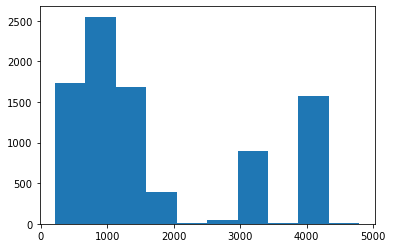

In [22]:
plt.hist(all_badtimes)

In [28]:
all_badtimes = np.array(list(set(all_badtimes)))

(273,)

In [27]:
badtimes.shape

(1, 144)